<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/RNN/GAN01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks 

## Construindo uma Rede Neural que aprende a gerar dígitos manuscritos

## Introdução

De acordo com Yann LeCun, "Adversarial training is the coolest thing since sliced bread.". O pão cortado certamente nunca criou essa excitação dentro da comunidade de aprendizado profundo. As redes adversárias generativas - ou os GANs - afiaram dramaticamente a possibilidade de conteúdo gerado por IA e desencadearam esforços de pesquisa ativos desde que foram descitos por [Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661). Os GANs são redes neurais que aprendem a criar dados sintéticos semelhantes a alguns dados de entrada conhecidos.

## Arquitetura GAN 

Generative adversarial networks consistem de 2 modelos: modelo generativo e modelo discriminativo.

![caption](images/GAN_Overall.png)

O modelo discriminativo é um classificador que determina se uma determinada imagem se parece com uma imagem real do conjunto de dados ou como uma imagem criada artificialmente. Este é basicamente um classificador binário que assumirá a forma de uma rede neural convolucional normal (CNN).

O modelo generativo possui valores de entrada aleatórios e os transforma em imagens através de uma rede neural deconvolucional.

Ao longo de muitas iterações de treinamento, os pesos e os bias nos modelos discriminativo e o generativo são treinados através de backpropagation. O modelo discriminativo aprende a identificar imagens "reais" de dígitos manuscritos além das imagens "falsas" criadas pelo modelo generativo. Ao mesmo tempo, o modelo generativo usa as perdas do modelo discriminativo para aprender a produzir imagens convincentes que o modelo discriminativo não consegue mais distinguir de imagens reais.

## Carregando o Dataset

In [0]:
!nvidia-smi

Thu Jan 24 15:53:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:05:00.0 Off |                  N/A |
| 25%   44C    P8    16W / 250W |     10MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 23%   36C    P8    17W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [0]:
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


A variável MNIST que criamos acima contém as imagens e os seus rótulos, divididos em um conjunto de treinamento chamado `train` e um conjunto de validação chamado `validation`. (Não precisamos nos preocupar com os rótulos). Podemos recuperar lotes de imagens chamando `next_batch` no `mnist`. Vamos carregar uma imagem.

As imagens são formatadas inicialmente como uma única linha de 784 pixels. Podemos remodelá-los em imagens de 28 x 28 pixels e visualizá-las usando pyplot.

(1, 784)


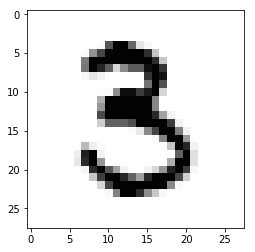

In [0]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

## Discriminator Network

Nosso modelo discriminativo é uma rede neural convolucional que recebe uma imagem de tamanho 28 x 28 x 1 como entrada e retorna um único número escalar que descreve se a imagem de entrada é ou não "real" ou "falsa" - ou seja, seja desenhada do conjunto de imagens MNIST ou geradas pelo modelo generativo.

![caption](images/GAN_Discriminator.png)

A estrutura do nosso modelo modelo discriminativo é baseada em [TensorFlow's sample CNN classifier model](https://www.tensorflow.org/get_started/mnist/pros). Possui duas camadas convolucionais que encontram recursos de 5x5 pixels e duas camadas "totalmente conectadas" que multiplicam pesos por cada pixel na imagem.

Para configurar cada camada, começamos por criar variáveis de peso e bias através de [`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable). Os pesos são inicializados de uma distribuição [truncated normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) e os bias são inicializados em zero.

[`tf.nn.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) é a função de convolução padrão do TensorFlow. Recebe 4 argumentos. O primeiro é o volume de entrada (nossas imagens `28 x 28 x 1` neste caso). O próximo argumento é a matriz filtro / peso. Finalmente, você também pode mudar o stride e o padding da convolução. Esses dois valores afetam as dimensões do volume de saída.

Se você já está confortável com CNNs, você reconhecerá isso como um simples classificador binário - nada extravagante.

In [0]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # Primeira camada de convolução e de pooling
        # São 32 features diferentes de 5 x 5 pixels
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer = tf.truncated_normal_initializer(stddev = 0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer = tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input = images, filter = d_w1, strides=[1, 1, 1, 1], padding = 'SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        # Segunda camada de convolução e de pooling
        # São 64 features diferentes de 5 x 5 pixels
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer = tf.truncated_normal_initializer(stddev = 0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer = tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input = d1, filter = d_w2, strides = [1, 1, 1, 1], padding = 'SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        # Primeira camada totalmente conectada
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer = tf.truncated_normal_initializer(stddev = 0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer = tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Segunda camada totalmente conectada
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer = tf.truncated_normal_initializer(stddev = 0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer = tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # Resultado do modelo discriminativo
        return d4

## Generator Network

![caption](images/GAN_Generator.png)

Agora que temos o nosso modelo discriminativo definido, vamos dar uma olhada no modelo generativo. 

Você pode pensar no modelo generativo como um tipo de rede neural convolutiva reversa (Deconvolutional). Uma CNN típica como a nossa rede discriminativa transforma uma matriz de valores de pixel de 2 ou 3 dimensões em uma única probabilidade. Um gerador, no entanto, recebe um vetor de ruído com `d` dimensões e o faz subir para uma imagem de 28 x 28. A ReLU e a normalização do lote são usadas para estabilizar as saídas de cada camada.

Na nossa rede geradora, usamos três camadas convolucionais, juntamente com a interpolação, até formar uma imagem de pixel "28 x 28". 

Na camada de saída, adicionamos uma função de ativação [`tf.sigmoid()` (https://www.tensorflow.org/api_docs/python/tf/sigmoid). Isso "espreme" os pixels que pareceriam cinza em preto ou branco, resultando em uma imagem mais nítida.

BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

In [0]:
def generator(z, batch_size, z_dim):
    # Camada 1
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Gerando 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Gerando 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Convolução final com um canal de saída
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensões de g4: batch_size x 28 x 28 x 1
    return g4

## Gerando uma Amostra de Imagem

Agora que já definimos as funções dos modelos discriminativo e generativo, vamos ver o que uma saída de amostra de um gerador não treinado parece.

Precisamos abrir uma sessão TensorFlow e criar um espaço reservado (placeholder) para a entrada do nosso gerador. O shape do espaço reservado será "None, z_dimensões". A palavra-chave `None` significa que o valor pode ser determinado no tempo de execução da sessão. Normalmente, nós temos "None" como nossa primeira dimensão para que possamos ter tamanhos de lote variáveis. (Com um tamanho de lote de 50, a entrada para o gerador seria de 50 x 100). Com a opção "None", não precisamos especificar `batch_size` até mais tarde.

In [0]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

Agora, criamos uma variável (`generate_image_output`) que contém a saída do gerador e também inicializaremos o vetor de ruído aleatório que vamos usar como entrada. A função [`np.random.normal ()`] (https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) tem três argumentos. O primeiro e o segundo definem o desvio padrão e médio para a distribuição normal (0 e 1 no nosso caso) e o terceiro define a forma do vetor (`1 x 100`).

In [0]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

Em seguida, inicializamos todas as variáveis, alimentamos o `z_batch` no espaço reservado e executamos a sessão.

A função [`sess.run ()`] (https://www.tensorflow.org/api_docs/python/tf/Session#run) possui dois argumentos. O primeiro é chamado de argumento "fetches"; define o valor que lhe interessa na computação. No nosso caso, queremos ver qual é a saída do gerador. Se você olhar para o último trecho de código, você verá que a saída da função do gerador é armazenada em `generated_image_output`, então usaremos `generated_image_output` para o nosso primeiro argumento.

O segundo argumento recebe um dicionário de entradas que são substituídas no grafo quando ele é executado. É aí que nós alimentamos nossos espaços reservados. No nosso exemplo, precisamos alimentar nossa variável `z_batch` no `z_placeholder` que definimos anteriormente. Como antes, veremos a imagem remodelando-a para os pixels '28 x 28' e mostramos com o PyPlot.

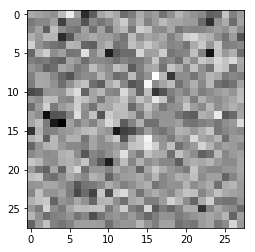

In [0]:
# Visualizando a saída do Generator antes do treinamento
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output, feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

Nada foi aprendido, pois não houve treinamento. Agora precisamos treinar os pesos e os bias na rede geradora para converter números aleatórios em dígitos reconhecíveis. Olhemos para as funções de perda e otimização!

## Treinando o Modelo GAN

Uma das partes mais complicadas sobre a criação e ajuste de GANs é que eles têm duas funções de perda: uma que incentiva o gerador a criar imagens melhores e a outra que encoraja o discriminador a distinguir imagens geradas de imagens reais.

Treinamos tanto o gerador quanto o discriminador simultaneamente. À medida que o discriminador melhora em distinguir imagens reais de imagens geradas, o gerador é capaz de melhor ajustar seus pesos e distorções para gerar imagens convincentes.

Aqui estão as entradas e saídas para nossas redes.

In [0]:
tf.reset_default_graph()
batch_size = 50

# Input noise no modelo generativo
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 

# Input image no modelo discriminativo
x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 

# Imagens geradas
Gz = generator(z_placeholder, batch_size, z_dimensions) 

# Previsões de probabilidade do modelo discriminativo
# Para imagens reais do MNIST
Dx = discriminator(x_placeholder) 

# Previsões de probabilidade para as imagens geradas
Dg = discriminator(Gz, reuse_variables=True)

Então, primeiro pensemos sobre o que queremos de nossas redes. O objetivo do discriminador é classificar corretamente as imagens MNIST reais como reais (retornar uma saída com probabilidade mais alta) e gerar imagens como falsas (retornar uma saída mais baixa). Calculamos duas perdas para o discriminador: uma perda que compara `Dx` e 1 para imagens reais do conjunto MNIST, bem como uma perda que compara `Dg` e 0 para imagens do gerador. Faremos isso com a função [`tf.nn.sigmoid_cross_entropy_with_logits ()`] do TensorFlow (https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits), que calcula as perdas entre entropia entre `Dx` e 1 e entre `Dg` e 0.

`sigmoid_cross_entropy_with_logits` opera em valores não escalados em vez de valores de probabilidade de 0 a 1. Dê uma olhada na última linha do nosso discriminador: não há camada softmax ou sigmoid no final. Os GANs podem falhar se seus discriminadores "saturarem", ou se confiar o suficiente para retornar exatamente 0 quando receberem uma imagem gerada; que deixa o discriminador sem um gradiente útil para descer.

A função [`tf.reduce_mean ()`] (https://www.tensorflow.org/api_docs/python/tf/reduce_mean) assume o valor médio de todos os componentes na matriz retornada pela função de entropia cruzada. Esta é uma maneira de reduzir a perda para um único valor escalar, em vez de um vetor ou matriz.

In [0]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

Agora vamos configurar a função de perda do gerador. Queremos que a rede geradora crie imagens que enganarão o discriminador: o gerador quer que o discriminador publique um valor próximo de 1 quando é dada uma imagem do gerador. Portanto, queremos calcular a perda entre `Dg` e 1.

In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))  

Agora que temos nossas funções de perda, precisamos definir nossos otimizadores. O otimizador para a rede geradora precisa atualizar apenas os pesos do gerador, e não os do discriminador. Da mesma forma, quando treinamos o discriminador, queremos manter os pesos do gerador resolvidos.

Para fazer essa distinção, precisamos criar duas listas de variáveis, uma com os pesos e os preconceitos do discriminador e outra com os pesos e preconceitos do gerador. É aqui que nomear todas as suas variáveis TensorFlow com um esquema pensativo pode ser útil.

In [0]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


Em seguida, especificamos nossos dois otimizadores. [Adam] (https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) geralmente é o algoritmo de otimização de escolha para GANs; ele utiliza taxas de aprendizagem adaptativa e impulso. Chamamos a função de minimizar de Adão e também especificamos as variáveis que queremos que atualizem - os pesos e os distúrbios do gerador quando treinamos o gerador e os pesos e vies do discriminador quando treinamos o discriminador.

Estamos configurando duas operações de treinamento diferentes para o discriminador aqui: uma que treina o discriminador em imagens reais e uma que treina o discrmnator em imagens falsas. Às vezes, é útil usar diferentes taxas de aprendizagem para essas duas operações de treinamento, ou usá-las separadamente para [regular a aprendizagem de outras maneiras] (https://github.com/jonbruner/ezgan).

In [0]:
# Treinando o modelo discriminativo
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Treinando o modelo generativo
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

Pode ser complicado fazer com que os GANs convergem e, além disso, muitas vezes eles precisam treinar por muito tempo. [TensorBoard] (https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) é útil para rastrear o processo de treinamento; Ele pode representar propriedades escalares como perdas, exibir imagens de amostra durante o treino e ilustrar a topologia das redes neurais.

Se você executar este script em sua própria máquina, inclua a célula abaixo. Então, em uma janela do terminal do diretório em que este caderno reside, execute

```
tensorboard --logdir=tensorboard/
```

e abra o TensorBoard visitando [`http: // localhost: 6006`] (http: // localhost: 6006) em seu navegador da Web.

In [0]:
# Variáveis
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

E agora nós iteramos. Começamos dando brevemente ao discriminador algum treinamento inicial; Isso ajuda a desenvolver um gradiente útil para o gerador.

Em seguida, avançamos para o ciclo principal de treinamento. Quando formamos o gerador, alimentaremos um vetor 'z' aleatório no gerador e passamos a saída para o discriminador (esta é a variável `Dg` que especificamos anteriormente). Os pesos e bias do gerador serão atualizados para produzir imagens que o discriminador é mais provável que classifique como real.

Para treinar o discriminador, alimentaremos um lote de imagens do conjunto MNIST para servir como exemplos positivos e, em seguida, treinamos o discriminador novamente em imagens geradas, usando-os como exemplos negativos. Lembre-se de que, à medida que o gerador melhora a sua saída, o discriminador continua a aprender a classificar as imagens do gerador melhoradas como falsas.

** Se você quiser executar este código, prepare-se para aguardar: demora cerca de 40 minutos em uma GPU, mas pode demorar dez vezes mais em uma CPU desktop. **

dLossReal: 0.692322 dLossFake: 0.721108
dLossReal: 0.0704192 dLossFake: 0.265723
dLossReal: 0.000764845 dLossFake: 0.00199787
Iteração: 0 at 2019-01-24 15:54:54.055042


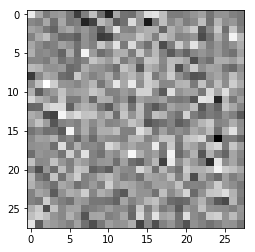

Estimativa: [[-6.69306517]]
Iteração: 100 at 2019-01-24 15:55:55.698656


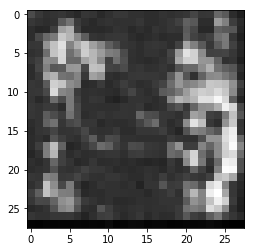

Estimativa: [[-4.68086004]]
Iteração: 200 at 2019-01-24 15:56:57.356740


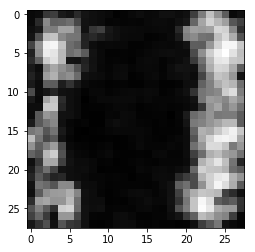

Estimativa: [[-8.09489346]]
Iteração: 300 at 2019-01-24 15:57:59.629987


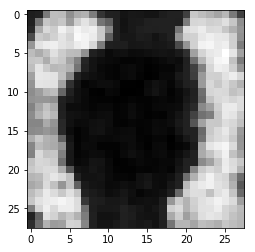

Estimativa: [[-9.19427967]]
Iteração: 400 at 2019-01-24 15:59:01.457452


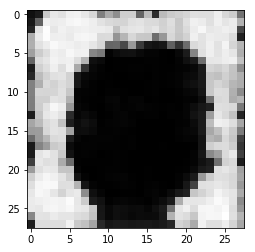

Estimativa: [[-10.94727612]]
Iteração: 500 at 2019-01-24 16:00:03.410505


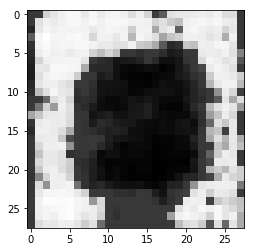

Estimativa: [[-9.96259022]]
Iteração: 600 at 2019-01-24 16:01:05.513620


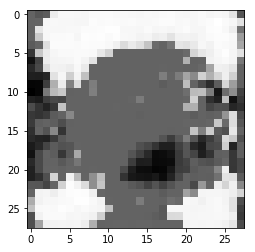

Estimativa: [[-9.95550442]]
Iteração: 700 at 2019-01-24 16:02:07.411413


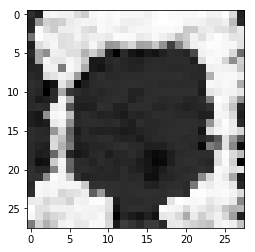

Estimativa: [[-12.81403351]]
Iteração: 800 at 2019-01-24 16:03:09.630475


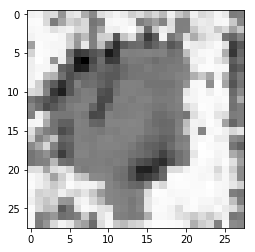

Estimativa: [[-10.06570721]]
Iteração: 900 at 2019-01-24 16:04:11.633118


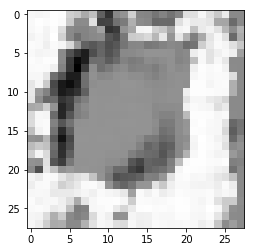

Estimativa: [[-9.76673794]]
Iteração: 1000 at 2019-01-24 16:05:13.923238


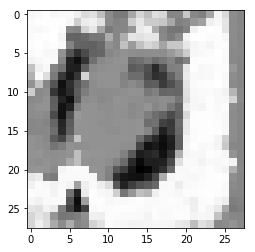

Estimativa: [[-9.26367569]]
Iteração: 1100 at 2019-01-24 16:06:15.503851


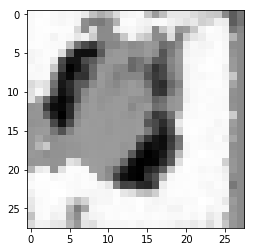

Estimativa: [[-7.78484821]]
Iteração: 1200 at 2019-01-24 16:07:17.491853


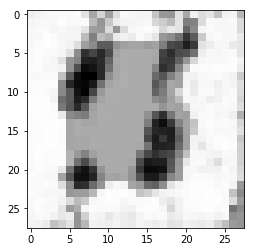

Estimativa: [[-8.21631145]]
Iteração: 1300 at 2019-01-24 16:08:19.462695


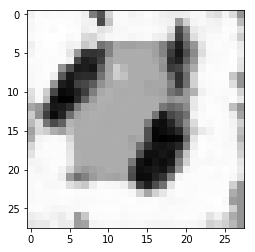

Estimativa: [[-7.69880533]]
Iteração: 1400 at 2019-01-24 16:09:22.101636


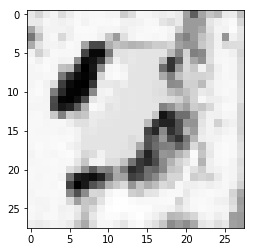

Estimativa: [[-9.63125801]]
Iteração: 1500 at 2019-01-24 16:10:24.452499


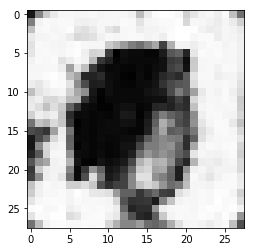

Estimativa: [[-15.02661705]]
Iteração: 1600 at 2019-01-24 16:11:25.957085


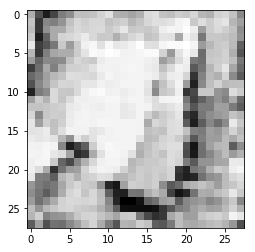

Estimativa: [[-18.64458084]]
Iteração: 1700 at 2019-01-24 16:12:28.105239


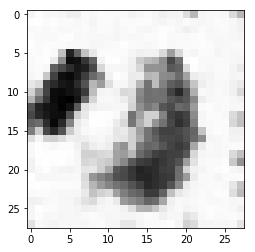

Estimativa: [[-7.50238371]]
Iteração: 1800 at 2019-01-24 16:13:30.363416


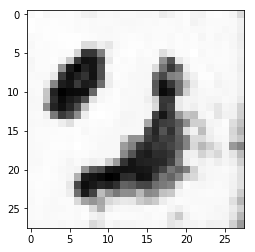

Estimativa: [[-8.43645573]]
Iteração: 1900 at 2019-01-24 16:14:32.689991


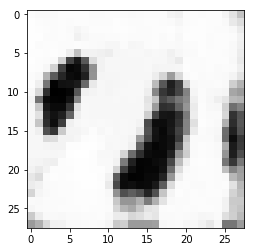

Estimativa: [[-6.29608822]]
Iteração: 2000 at 2019-01-24 16:15:35.253092


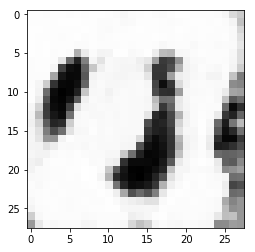

Estimativa: [[-6.6912632]]
Iteração: 2100 at 2019-01-24 16:16:36.887250


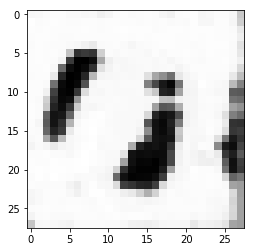

Estimativa: [[-9.17686939]]
Iteração: 2200 at 2019-01-24 16:17:39.236469


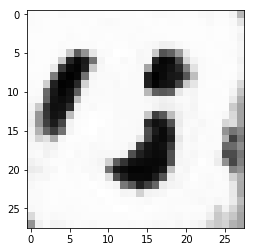

Estimativa: [[-6.6718111]]
Iteração: 2300 at 2019-01-24 16:18:41.215576


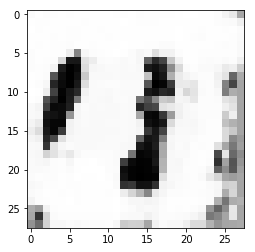

Estimativa: [[-9.43978119]]
Iteração: 2400 at 2019-01-24 16:19:43.068455


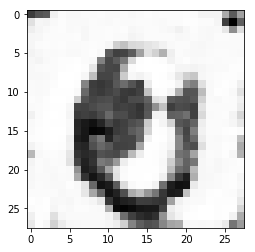

Estimativa: [[-30.33661652]]
Iteração: 2500 at 2019-01-24 16:20:45.198960


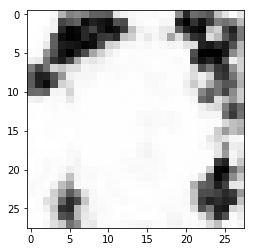

Estimativa: [[-11.16428947]]
Iteração: 2600 at 2019-01-24 16:21:47.235958


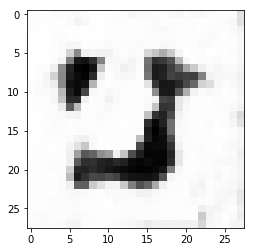

Estimativa: [[-14.31516933]]
Iteração: 2700 at 2019-01-24 16:22:49.834937


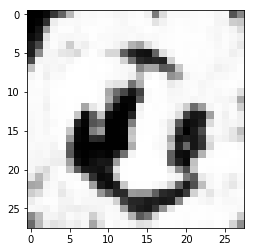

Estimativa: [[-33.04737854]]
Iteração: 2800 at 2019-01-24 16:23:52.046066


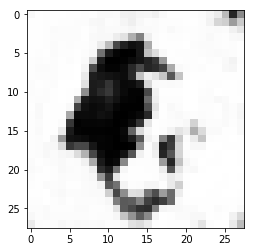

Estimativa: [[-13.01970387]]
Iteração: 2900 at 2019-01-24 16:24:54.314958


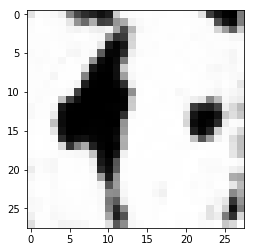

Estimativa: [[-4.80557489]]
Iteração: 3000 at 2019-01-24 16:25:56.615660


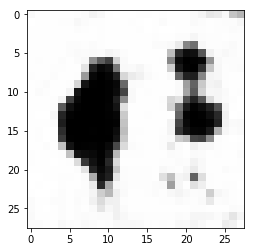

Estimativa: [[-8.21376801]]
Iteração: 3100 at 2019-01-24 16:26:58.874945


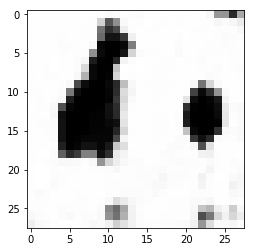

Estimativa: [[-12.94785595]]
Iteração: 3200 at 2019-01-24 16:28:01.528332


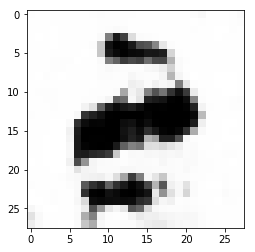

Estimativa: [[-30.08442879]]
Iteração: 3300 at 2019-01-24 16:29:03.330070


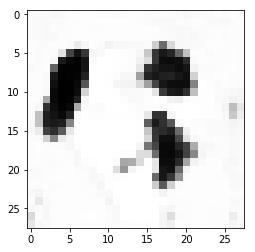

Estimativa: [[-21.56671524]]
Iteração: 3400 at 2019-01-24 16:30:05.870326


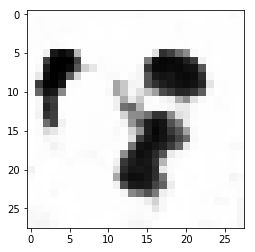

Estimativa: [[-97.86431122]]
Iteração: 3500 at 2019-01-24 16:31:07.588626


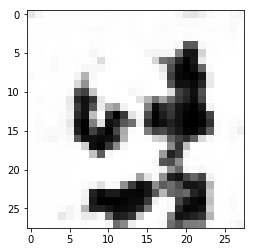

Estimativa: [[-10.16759968]]
Iteração: 3600 at 2019-01-24 16:32:10.051380


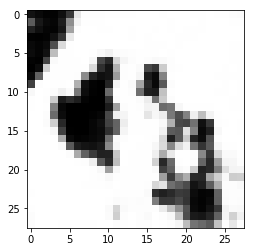

Estimativa: [[-25.98109055]]
Iteração: 3700 at 2019-01-24 16:33:12.207531


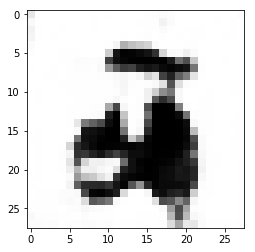

Estimativa: [[-57.32791138]]
Iteração: 3800 at 2019-01-24 16:34:14.542171


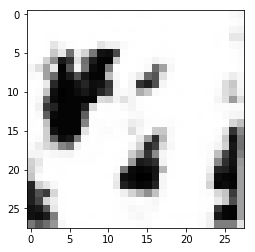

Estimativa: [[-55.64405441]]
Iteração: 3900 at 2019-01-24 16:35:16.871868


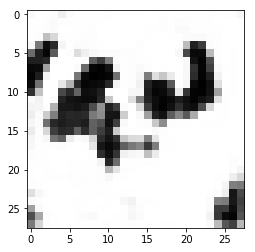

Estimativa: [[-63.27873611]]
Iteração: 4000 at 2019-01-24 16:36:19.248923


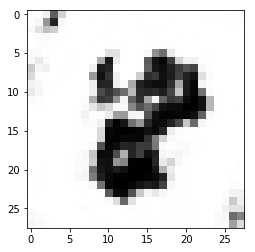

Estimativa: [[-102.34729767]]
Iteração: 4100 at 2019-01-24 16:37:21.927881


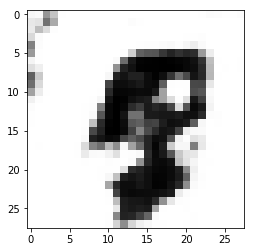

Estimativa: [[-76.66555023]]
Iteração: 4200 at 2019-01-24 16:38:24.334434


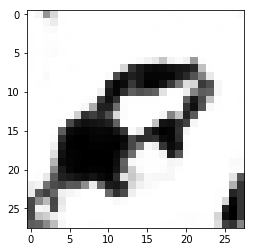

Estimativa: [[-104.90552521]]
Iteração: 4300 at 2019-01-24 16:39:26.277630


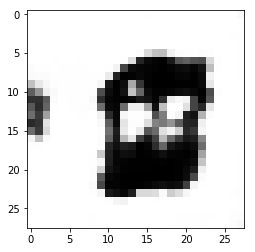

Estimativa: [[-77.51069641]]
Iteração: 4400 at 2019-01-24 16:40:28.586922


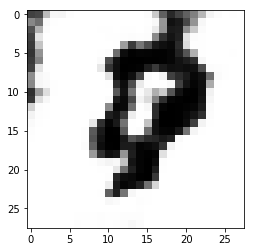

Estimativa: [[-43.00014877]]
Iteração: 4500 at 2019-01-24 16:41:29.667042


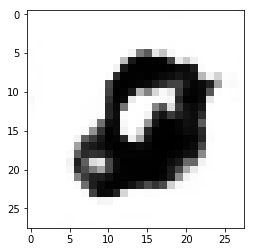

Estimativa: [[-107.64151001]]
Iteração: 4600 at 2019-01-24 16:42:31.282546


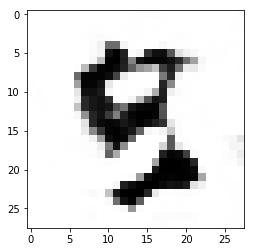

Estimativa: [[-68.93713379]]
Iteração: 4700 at 2019-01-24 16:43:37.044522


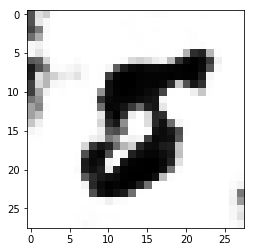

Estimativa: [[-74.63359833]]
Iteração: 4800 at 2019-01-24 16:45:07.235531


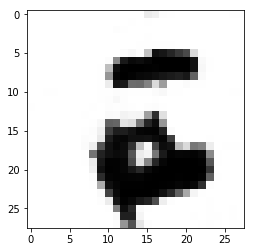

Estimativa: [[-16.79186058]]
Iteração: 4900 at 2019-01-24 16:46:37.505143


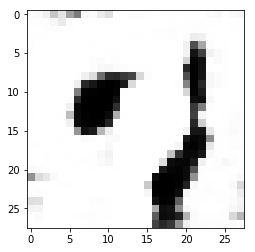

Estimativa: [[-121.80726624]]
Iteração: 5000 at 2019-01-24 16:48:06.860036


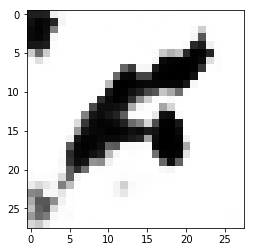

Estimativa: [[-99.09555054]]
Iteração: 5100 at 2019-01-24 16:49:36.161436


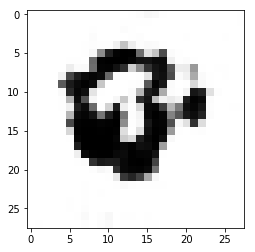

Estimativa: [[-75.96971893]]
Iteração: 5200 at 2019-01-24 16:51:06.910497


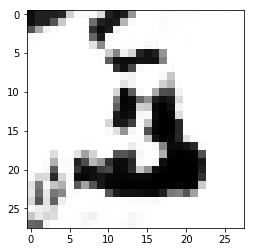

Estimativa: [[-51.45517731]]
Iteração: 5300 at 2019-01-24 16:52:37.763253


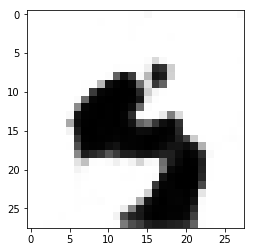

Estimativa: [[-42.93832016]]
Iteração: 5400 at 2019-01-24 16:54:05.749383


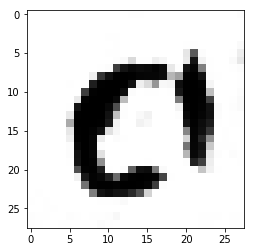

Estimativa: [[-31.40809631]]
Iteração: 5500 at 2019-01-24 16:55:36.228093


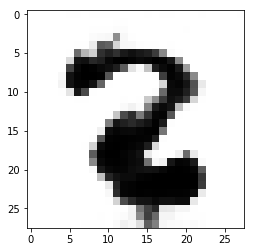

Estimativa: [[-50.34528351]]
Iteração: 5600 at 2019-01-24 16:57:06.189144


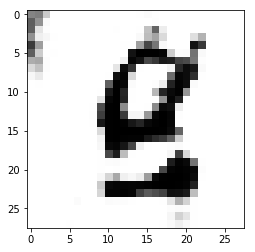

Estimativa: [[-28.07765961]]
Iteração: 5700 at 2019-01-24 16:58:33.960568


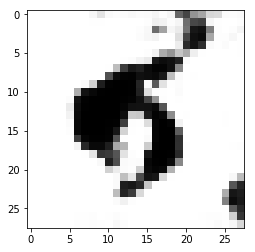

Estimativa: [[-47.10909271]]
Iteração: 5800 at 2019-01-24 17:00:04.536051


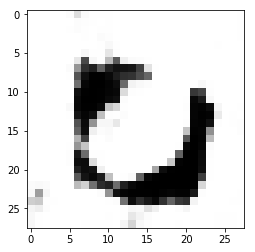

Estimativa: [[-36.25973129]]
Iteração: 5900 at 2019-01-24 17:01:34.763314


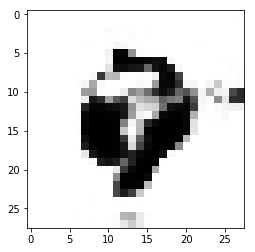

Estimativa: [[-38.2870903]]
Iteração: 6000 at 2019-01-24 17:03:02.722966


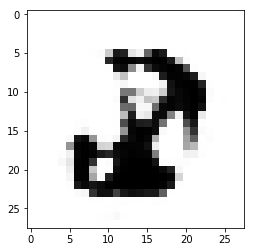

Estimativa: [[-34.49764633]]
Iteração: 6100 at 2019-01-24 17:04:33.224182


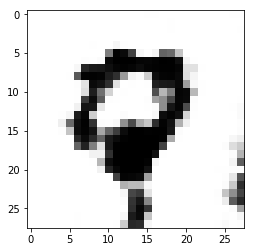

Estimativa: [[-21.27758598]]
Iteração: 6200 at 2019-01-24 17:06:03.148068


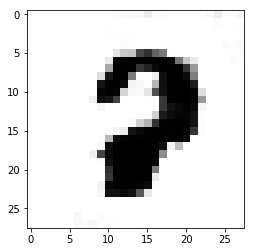

Estimativa: [[-7.71126938]]
Iteração: 6300 at 2019-01-24 17:07:31.121524


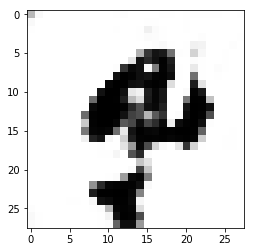

Estimativa: [[-22.65533447]]
Iteração: 6400 at 2019-01-24 17:09:01.503505


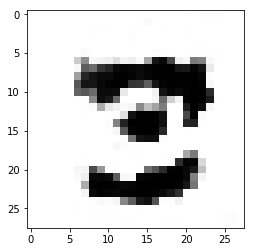

Estimativa: [[-18.80568314]]
Iteração: 6500 at 2019-01-24 17:10:31.500255


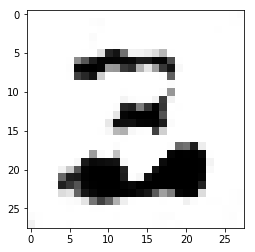

Estimativa: [[ 8.54654121]]
Iteração: 6600 at 2019-01-24 17:11:59.741589


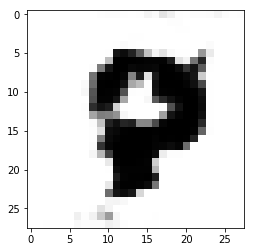

Estimativa: [[-10.49793625]]
Iteração: 6700 at 2019-01-24 17:13:29.665086


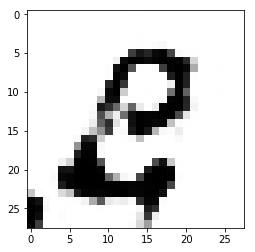

Estimativa: [[ 3.46744943]]
Iteração: 6800 at 2019-01-24 17:15:00.074835


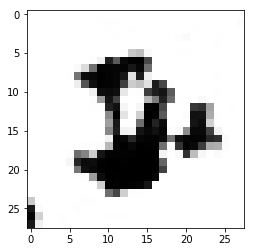

Estimativa: [[-13.01733112]]
Iteração: 6900 at 2019-01-24 17:16:30.549483


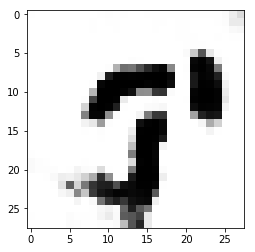

Estimativa: [[ 3.56907535]]
Iteração: 7000 at 2019-01-24 17:17:59.239895


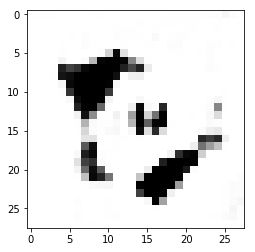

Estimativa: [[-21.54265976]]
Iteração: 7100 at 2019-01-24 17:19:29.665214


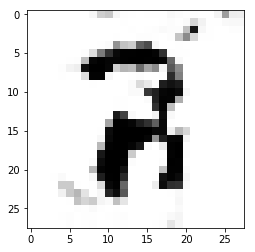

Estimativa: [[-15.75541687]]
Iteração: 7200 at 2019-01-24 17:20:59.368948


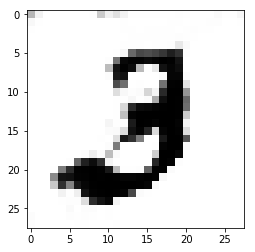

Estimativa: [[ 0.79136956]]
Iteração: 7300 at 2019-01-24 17:22:26.932675


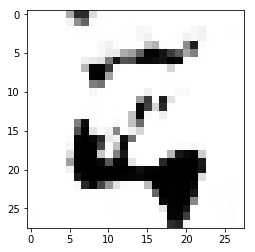

Estimativa: [[-2.81644773]]
Iteração: 7400 at 2019-01-24 17:23:58.114592


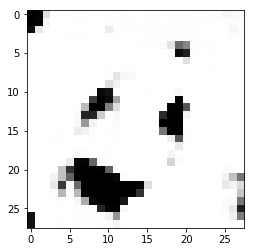

Estimativa: [[-28.5195446]]
Iteração: 7500 at 2019-01-24 17:25:28.409295


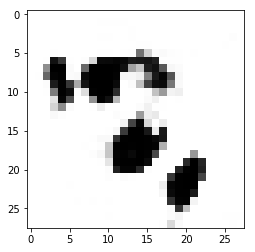

Estimativa: [[-28.06193352]]
Iteração: 7600 at 2019-01-24 17:26:55.843366


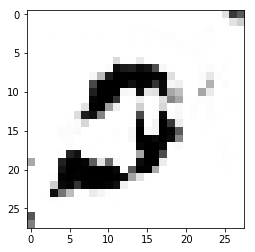

Estimativa: [[-15.07651711]]
Iteração: 7700 at 2019-01-24 17:28:26.275568


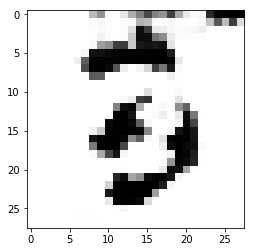

Estimativa: [[-6.99010897]]
Iteração: 7800 at 2019-01-24 17:29:56.579962


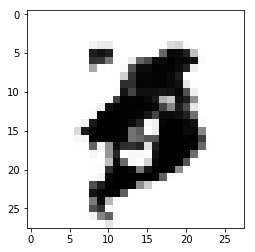

Estimativa: [[-38.53286743]]
Iteração: 7900 at 2019-01-24 17:31:25.079090


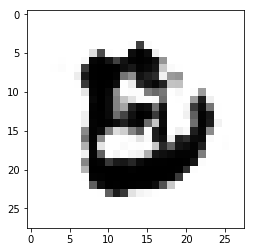

Estimativa: [[-8.68236637]]
Iteração: 8000 at 2019-01-24 17:32:55.356484


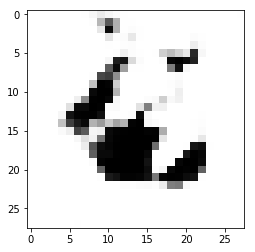

Estimativa: [[-34.43399811]]
Iteração: 8100 at 2019-01-24 17:34:25.692557


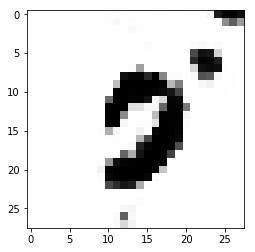

Estimativa: [[-19.48968315]]
Iteração: 8200 at 2019-01-24 17:35:53.661471


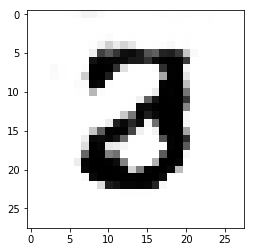

Estimativa: [[-3.54227734]]
Iteração: 8300 at 2019-01-24 17:37:24.139248


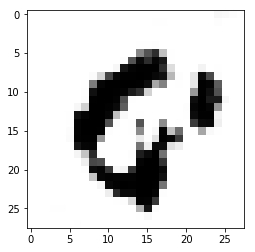

Estimativa: [[ 2.29175496]]
Iteração: 8400 at 2019-01-24 17:38:54.249769


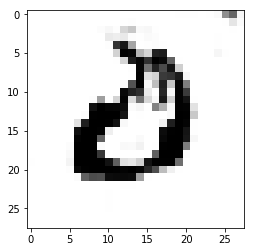

Estimativa: [[ 1.28482985]]
Iteração: 8500 at 2019-01-24 17:40:21.741973


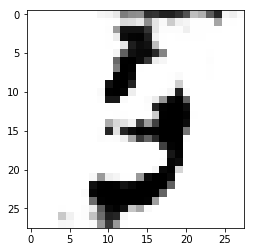

Estimativa: [[-5.84206867]]
Iteração: 8600 at 2019-01-24 17:41:52.405963


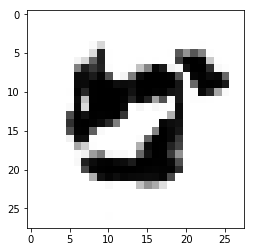

Estimativa: [[-15.53389168]]
Iteração: 8700 at 2019-01-24 17:43:23.509685


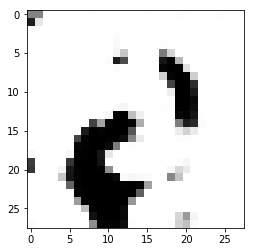

Estimativa: [[-3.4252069]]
Iteração: 8800 at 2019-01-24 17:44:53.914730


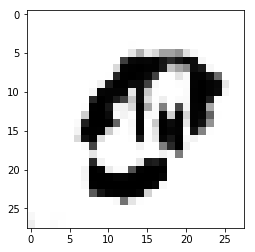

Estimativa: [[-8.74499416]]
Iteração: 8900 at 2019-01-24 17:46:22.434190


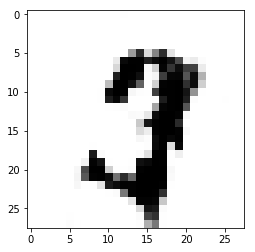

Estimativa: [[-2.31270528]]
Iteração: 9000 at 2019-01-24 17:47:52.820239


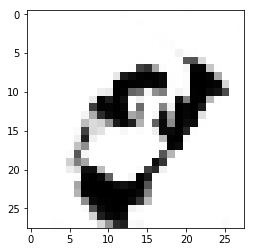

Estimativa: [[-11.19795227]]
Iteração: 9100 at 2019-01-24 17:49:23.155295


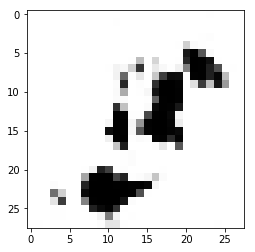

Estimativa: [[-24.54588509]]
Iteração: 9200 at 2019-01-24 17:50:51.056274


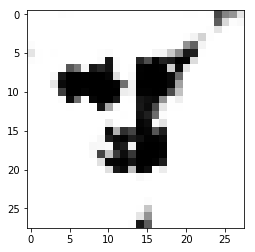

Estimativa: [[-21.55007553]]
Iteração: 9300 at 2019-01-24 17:52:22.167915


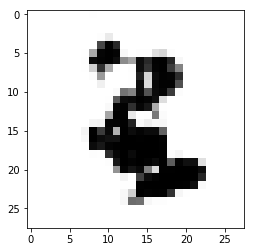

Estimativa: [[-9.93610287]]
Iteração: 9400 at 2019-01-24 17:53:53.188814


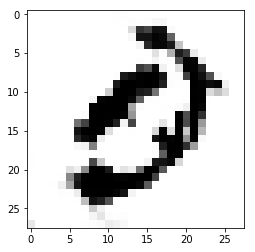

Estimativa: [[-10.8314743]]
Iteração: 9500 at 2019-01-24 17:55:21.023927


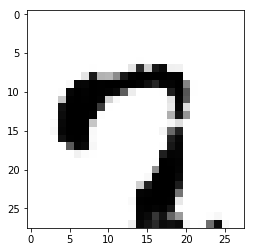

Estimativa: [[ 0.95907962]]
Iteração: 9600 at 2019-01-24 17:56:51.143504


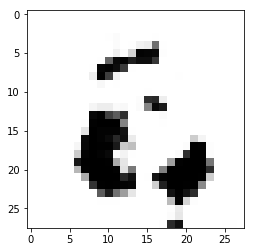

Estimativa: [[-5.97330904]]
Iteração: 9700 at 2019-01-24 17:58:21.844522


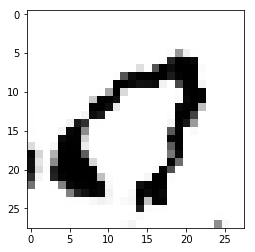

Estimativa: [[-5.00025558]]
Iteração: 9800 at 2019-01-24 17:59:49.728398


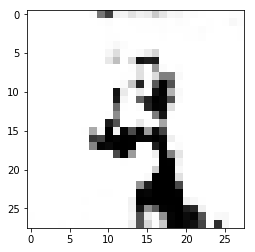

Estimativa: [[-33.01448059]]
Iteração: 9900 at 2019-01-24 18:01:20.615810


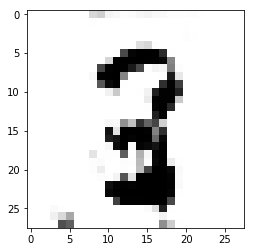

Estimativa: [[-10.32077885]]
Iteração: 10000 at 2019-01-24 18:02:50.990633


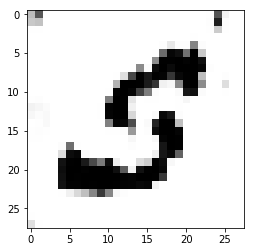

Estimativa: [[ 0.20130154]]
Iteração: 10100 at 2019-01-24 18:04:18.753539


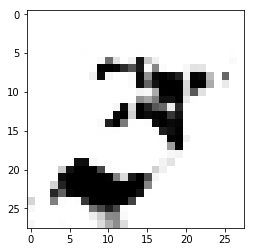

Estimativa: [[-18.92881012]]
Iteração: 10200 at 2019-01-24 18:05:48.805364


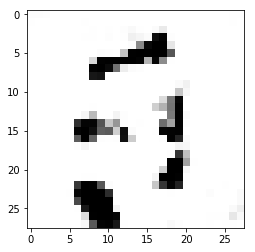

Estimativa: [[-16.51726341]]
Iteração: 10300 at 2019-01-24 18:07:19.137509


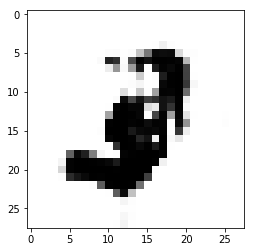

Estimativa: [[-21.86780739]]
Iteração: 10400 at 2019-01-24 18:08:46.765736


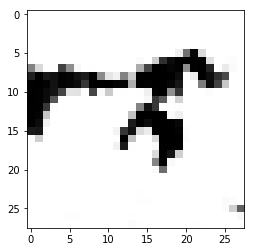

Estimativa: [[ 48.12493896]]
Iteração: 10500 at 2019-01-24 18:10:17.418816


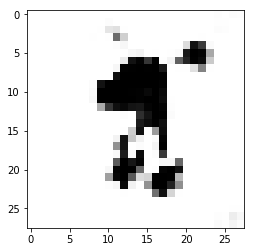

Estimativa: [[-6.89234686]]
Iteração: 10600 at 2019-01-24 18:11:48.352550


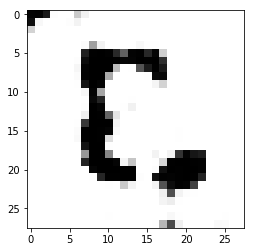

Estimativa: [[ 15.63045788]]
Iteração: 10700 at 2019-01-24 18:13:18.039382


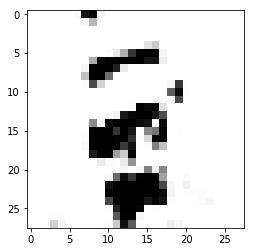

Estimativa: [[-13.38615036]]
Iteração: 10800 at 2019-01-24 18:14:46.201709


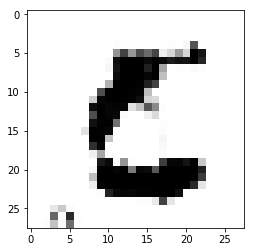

Estimativa: [[-14.91947651]]
Iteração: 10900 at 2019-01-24 18:16:16.659559


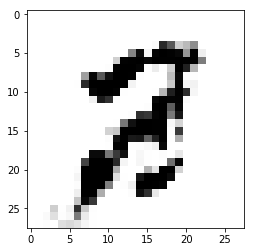

Estimativa: [[-13.72257996]]
Iteração: 11000 at 2019-01-24 18:17:47.417488


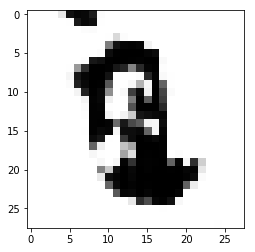

Estimativa: [[ 4.07356358]]
Iteração: 11100 at 2019-01-24 18:19:15.616929


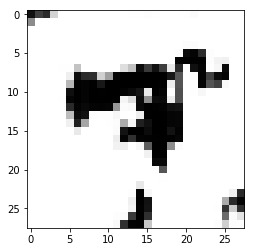

Estimativa: [[-31.01513863]]
Iteração: 11200 at 2019-01-24 18:20:45.528141


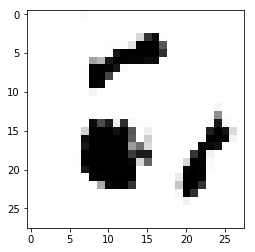

Estimativa: [[ 6.40485001]]
Iteração: 11300 at 2019-01-24 18:22:15.820024


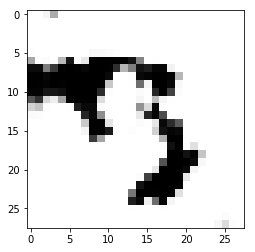

Estimativa: [[-25.84130669]]
Iteração: 11400 at 2019-01-24 18:23:44.221463


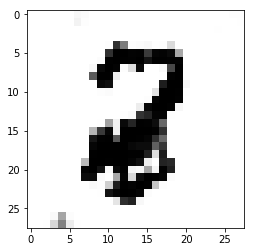

Estimativa: [[-13.50042152]]
Iteração: 11500 at 2019-01-24 18:25:14.305583


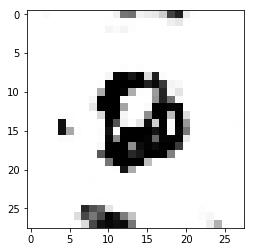

Estimativa: [[-20.26099777]]
Iteração: 11600 at 2019-01-24 18:26:44.765610


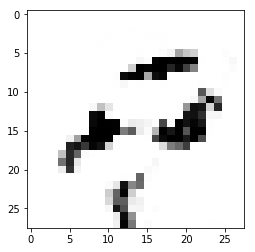

Estimativa: [[-27.07207489]]
Iteração: 11700 at 2019-01-24 18:28:12.901881


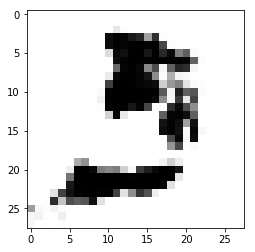

Estimativa: [[-17.82838058]]
Iteração: 11800 at 2019-01-24 18:29:43.204523


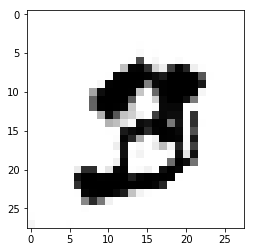

Estimativa: [[-6.76360559]]
Iteração: 11900 at 2019-01-24 18:31:13.361223


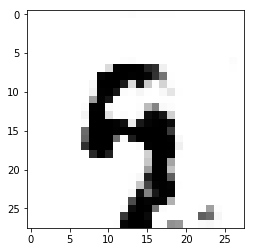

Estimativa: [[-14.55669785]]
Iteração: 12000 at 2019-01-24 18:32:40.825403


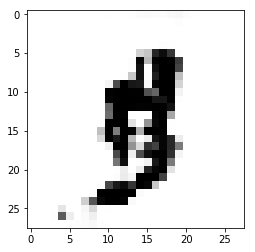

Estimativa: [[-11.63991451]]
Iteração: 12100 at 2019-01-24 18:34:11.083961


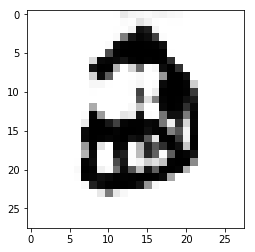

Estimativa: [[-26.17271233]]
Iteração: 12200 at 2019-01-24 18:35:41.631506


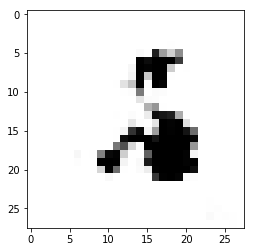

Estimativa: [[-29.05770493]]
Iteração: 12300 at 2019-01-24 18:37:09.301948


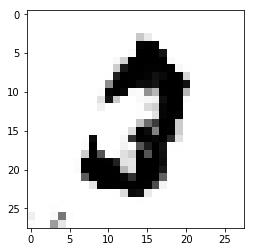

Estimativa: [[-12.93257809]]
Iteração: 12400 at 2019-01-24 18:38:39.324689


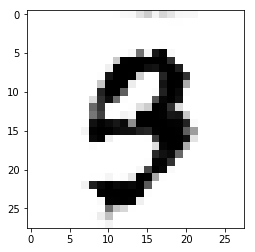

Estimativa: [[-10.46795464]]
Iteração: 12500 at 2019-01-24 18:40:10.140737


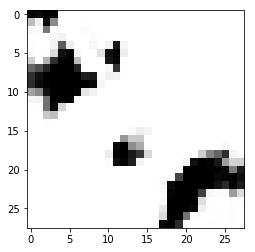

Estimativa: [[-11.13699055]]
Iteração: 12600 at 2019-01-24 18:41:40.161254


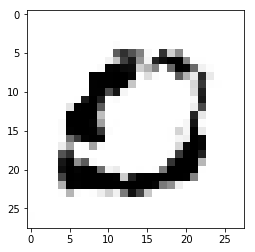

Estimativa: [[-11.28142548]]
Iteração: 12700 at 2019-01-24 18:43:09.204112


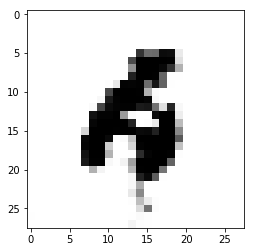

Estimativa: [[-3.87676597]]
Iteração: 12800 at 2019-01-24 18:44:40.352020


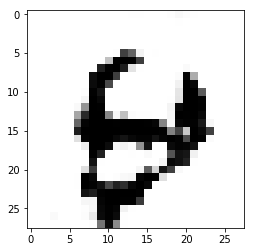

Estimativa: [[-4.55100298]]
Iteração: 12900 at 2019-01-24 18:46:11.162490


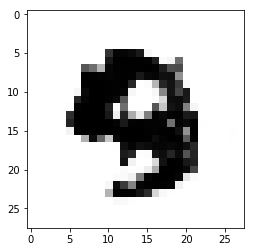

Estimativa: [[-25.09719276]]
Iteração: 13000 at 2019-01-24 18:47:39.735732


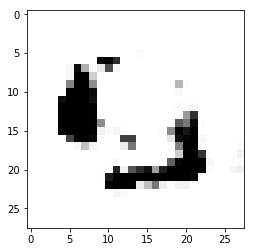

Estimativa: [[-6.27865791]]
Iteração: 13100 at 2019-01-24 18:49:10.340000


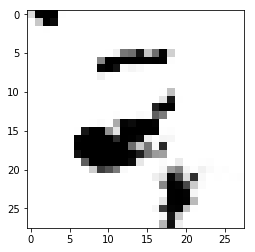

Estimativa: [[-4.45185995]]
Iteração: 13200 at 2019-01-24 18:50:40.693039


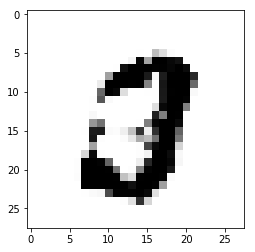

Estimativa: [[-16.84737396]]
Iteração: 13300 at 2019-01-24 18:52:09.201082


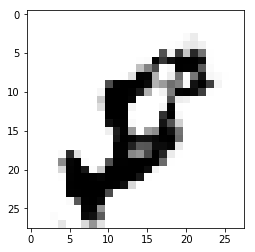

Estimativa: [[-10.60505199]]
Iteração: 13400 at 2019-01-24 18:53:39.993640


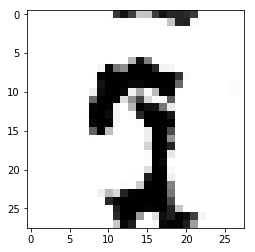

Estimativa: [[-11.10260296]]
Iteração: 13500 at 2019-01-24 18:55:11.094040


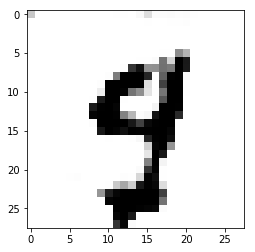

Estimativa: [[-13.03424835]]
Iteração: 13600 at 2019-01-24 18:56:38.767561


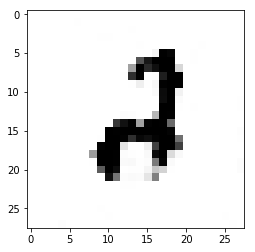

Estimativa: [[-10.70962048]]
Iteração: 13700 at 2019-01-24 18:58:09.665521


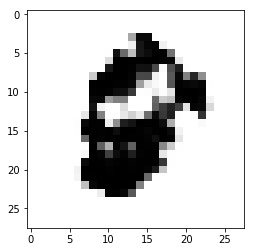

Estimativa: [[-15.32026482]]
Iteração: 13800 at 2019-01-24 18:59:39.968386


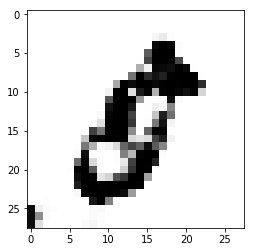

Estimativa: [[-1.69457185]]
Iteração: 13900 at 2019-01-24 19:01:08.196754


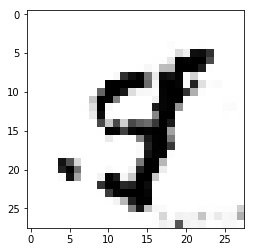

Estimativa: [[-6.0999918]]
Iteração: 14000 at 2019-01-24 19:02:38.709398


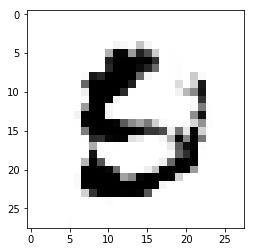

Estimativa: [[-19.60414886]]
Iteração: 14100 at 2019-01-24 19:04:09.297847


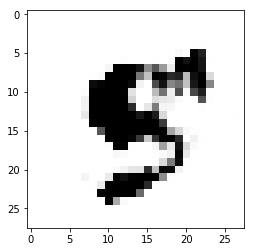

Estimativa: [[-12.81499577]]
Iteração: 14200 at 2019-01-24 19:05:37.015333


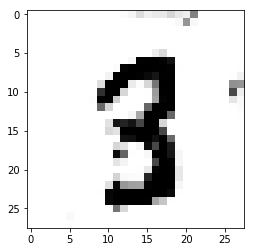

Estimativa: [[-17.82758904]]
Iteração: 14300 at 2019-01-24 19:07:07.136250


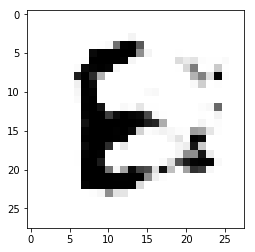

Estimativa: [[-53.06429672]]
Iteração: 14400 at 2019-01-24 19:08:37.489481


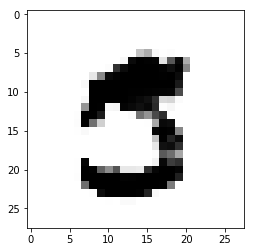

Estimativa: [[-16.40443611]]
Iteração: 14500 at 2019-01-24 19:10:06.210578


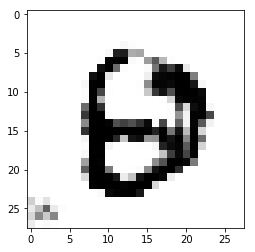

Estimativa: [[-10.45897198]]
Iteração: 14600 at 2019-01-24 19:11:36.086119


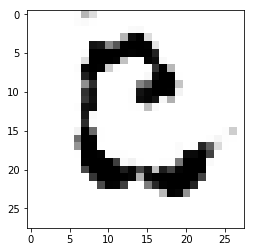

Estimativa: [[-12.01115227]]
Iteração: 14700 at 2019-01-24 19:13:06.580000


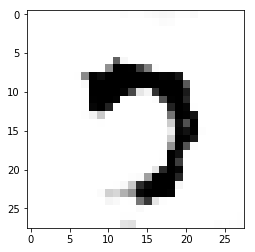

Estimativa: [[-22.88410378]]
Iteração: 14800 at 2019-01-24 19:14:36.837582


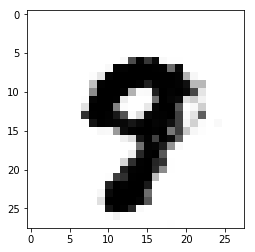

Estimativa: [[-28.41735649]]
Iteração: 14900 at 2019-01-24 19:16:05.126727


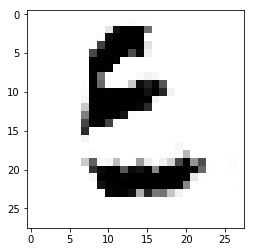

Estimativa: [[ 9.88580036]]
Iteração: 15000 at 2019-01-24 19:17:34.955833


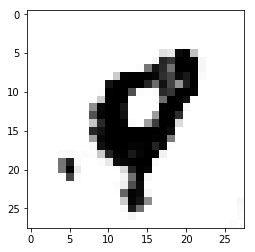

Estimativa: [[ 4.94829178]]
Iteração: 15100 at 2019-01-24 19:19:05.483830


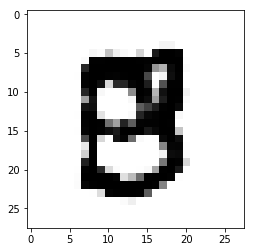

Estimativa: [[-22.22338867]]
Iteração: 15200 at 2019-01-24 19:20:32.827594


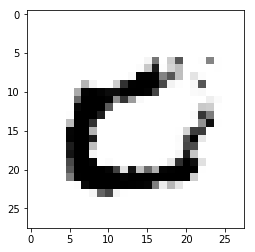

Estimativa: [[-7.75324965]]
Iteração: 15300 at 2019-01-24 19:22:03.448066


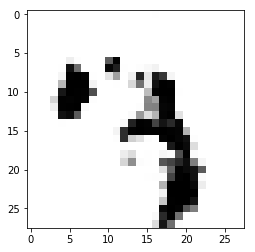

Estimativa: [[ 2.81597519]]
Iteração: 15400 at 2019-01-24 19:23:34.270888


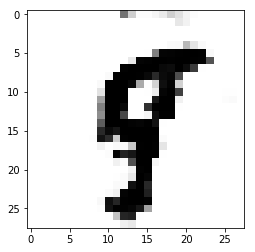

Estimativa: [[-17.24058533]]
Iteração: 15500 at 2019-01-24 19:25:02.834987


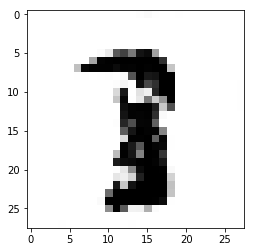

Estimativa: [[-15.68556404]]
Iteração: 15600 at 2019-01-24 19:26:33.434984


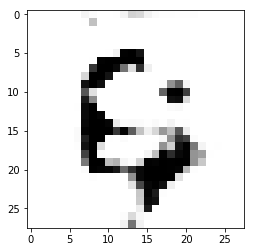

Estimativa: [[-33.9199028]]
Iteração: 15700 at 2019-01-24 19:28:04.223049


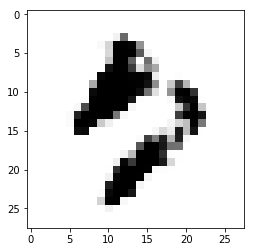

Estimativa: [[-5.34550381]]
Iteração: 15800 at 2019-01-24 19:29:32.637306


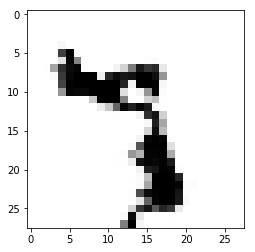

Estimativa: [[-11.65484524]]
Iteração: 15900 at 2019-01-24 19:31:02.722983


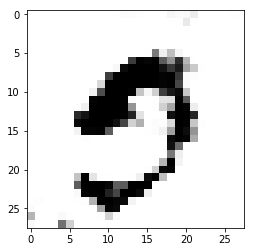

Estimativa: [[-21.7112484]]
Iteração: 16000 at 2019-01-24 19:32:33.216116


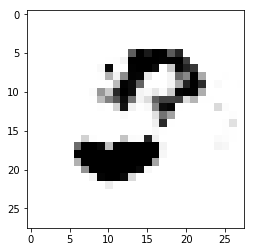

Estimativa: [[-3.92873406]]
Iteração: 16100 at 2019-01-24 19:34:00.957997


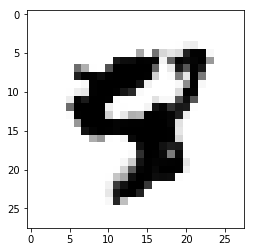

Estimativa: [[-24.28377914]]
Iteração: 16200 at 2019-01-24 19:35:31.275186


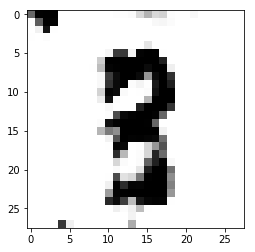

Estimativa: [[-35.70918655]]
Iteração: 16300 at 2019-01-24 19:37:01.564666


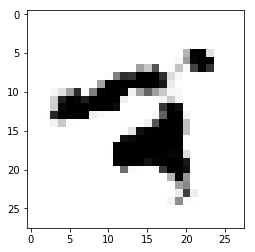

Estimativa: [[-11.61810493]]
Iteração: 16400 at 2019-01-24 19:38:29.762723


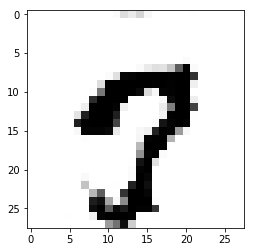

Estimativa: [[-24.68767166]]
Iteração: 16500 at 2019-01-24 19:40:00.524301


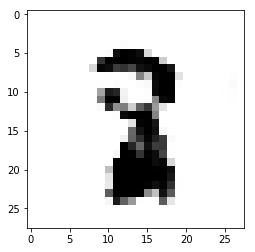

Estimativa: [[ 0.45558682]]
Iteração: 16600 at 2019-01-24 19:41:30.780293


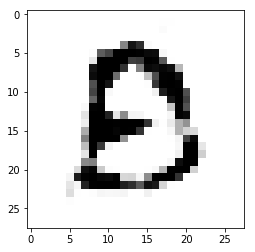

Estimativa: [[-35.40046692]]
Iteração: 16700 at 2019-01-24 19:43:01.555868


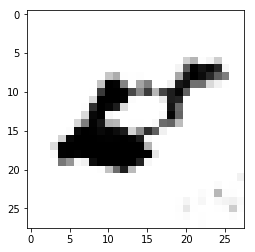

Estimativa: [[-3.46844029]]
Iteração: 16800 at 2019-01-24 19:44:29.784007


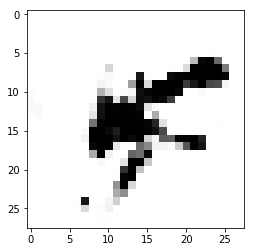

Estimativa: [[-16.82836151]]
Iteração: 16900 at 2019-01-24 19:46:01.110333


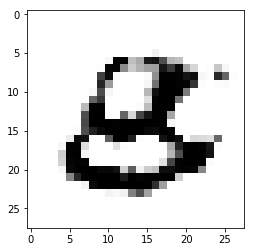

Estimativa: [[-15.14610291]]
Iteração: 17000 at 2019-01-24 19:47:31.914677


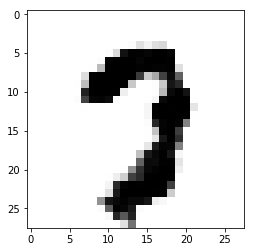

Estimativa: [[-13.00411606]]
Iteração: 17100 at 2019-01-24 19:48:59.726719


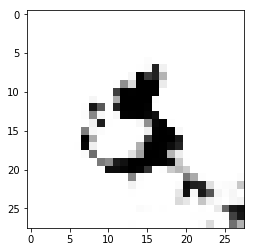

Estimativa: [[-44.72795486]]
Iteração: 17200 at 2019-01-24 19:50:30.420926


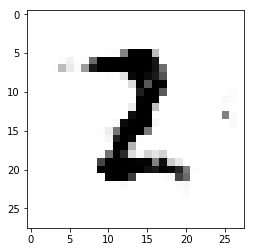

Estimativa: [[-9.70873833]]
Iteração: 17300 at 2019-01-24 19:52:00.918493


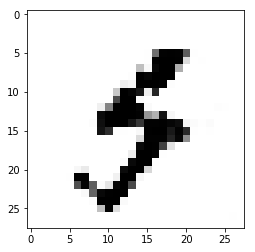

Estimativa: [[-5.53105021]]
Iteração: 17400 at 2019-01-24 19:53:28.364455


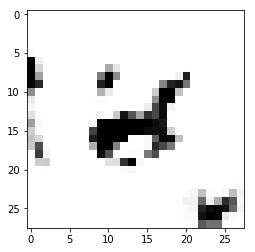

Estimativa: [[-30.19271088]]
Iteração: 17500 at 2019-01-24 19:54:58.866683


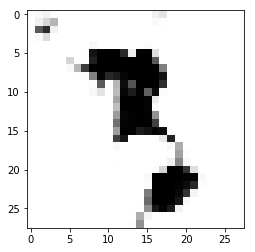

Estimativa: [[-12.23124695]]
Iteração: 17600 at 2019-01-24 19:56:29.463015


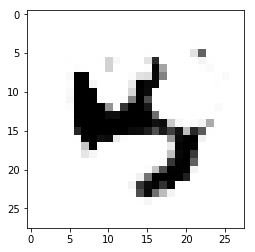

Estimativa: [[-15.80171871]]
Iteração: 17700 at 2019-01-24 19:57:57.865134


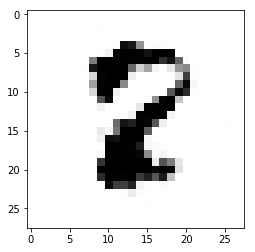

Estimativa: [[-15.14690304]]


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pré-treino do modelo discriminativo
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Treinar os modelos discriminativo e generativo juntos
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Treinando o modelo discriminativo nos dados reais e fake
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Treinando o modelo generativo
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Atualiza o TensorBoard com Estatísticas
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # A cada 100 iterações mostra uma imagem gerada
        print("Iteração:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimativa:", estimate)

## Dificuldades no Treinamento

Os GANs são notoriamente difíceis de treinar. Sem hiperparâmetros certos, arquitetura de rede e procedimento de treinamento, o discriminador pode dominar o gerador ou vice-versa.

Em um modo de falha comum, o discriminador supera o gerador, classificando as imagens geradas como falsas com certeza absoluta. Quando o discriminador responde com absoluta certeza, não deixa nenhum gradiente para o gerador descer. Isto ocorre, em parte, porque construímos o nosso discriminador para produzir um output não padronizado, em vez de passar a sua saída através de uma função sigmoide que empurraria a avaliação para 0 ou 1.

Em outro modo de falha comum conhecido como ** colapso do modo **, o gerador descobre e explora alguma fraqueza no discriminador. Você pode reconhecer o colapso do modo em seu GAN se ele gera muitas imagens muito semelhantes, independentemente da variação na entrada do gerador _z_. O colapso do modo às vezes pode ser corrigido por "fortalecer" o discriminador de alguma maneira - por exemplo, ajustando sua taxa de treinamento ou reconfigurando suas camadas.